
## Overdraft Charges - Large Dataset  
## (1000 customers, 2 million records)

### Machine Learning Backend 

#### Dataset size: 1000 customers across all customer segments: 
- Large corporate
- Mid-market corp
- Biz. banking upper
- Biz. banking mass 

#### Prediction Model Tuning and Evaluation 

*Author: Dr. Rashed Karim, AI CoE*


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numpy import random
import seaborn as sns 
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

####  Load 2+ million rows in the data into memory

In [90]:
df = pd.read_csv('EY_overdraft_charges_1000customers_1538_26062019.csv')
#df = pd.read_csv('Ey_overdraft_charges_1000customers_1040_22062019.csv')

#### A slice through the data

In [91]:
df__ = df.drop_duplicates('customer_id')
df__[['customer_id','customer_segment','time','balance','band1','band2','band3','band1_rate','band2_rate','band1_limit','band2_limit','charge']].head()

customer_id customer_segment        time  balance  band1  band2  band3  \
0         2511325              MMC  17-06-2018      360   0.00    0.0      0   
365       3826500              BBU  17-06-2018      -40   0.01    0.0      0   
730       4311675              BBU  17-06-2018      270   0.00    0.0      0   
1095      3641089              BBM  17-06-2018      690   0.00    0.0      0   
1460      3335414              BBM  17-06-2018      910   0.00    0.0      0   

      band1_rate  band2_rate  band1_limit  band2_limit  charge  
0            0.0         0.0          0.0          0.0    0.00  
365          7.2         6.4       6000.0      14000.0    0.01  
730          0.0         0.0          0.0          0.0    0.00  
1095         0.0         0.0          0.0          0.0    0.00  
1460         0.0         0.0          0.0          0.0    0.00

#### Some summary statistics on this data

In [92]:
df__.describe()

Unnamed: 0   customer_id  seasonal_index     balance      band1  \
count    10.000000  1.000000e+01       10.000000   10.000000  10.000000   
mean   1642.500000  3.556223e+06       11.056958  457.000000   0.001000   
std    1105.092379  2.159179e+06       13.359645  339.511086   0.003162   
min       0.000000  1.088848e+06        1.205030  -40.000000   0.000000   
25%     821.250000  1.951403e+06        2.124918  240.000000   0.000000   
50%    1642.500000  3.488252e+06        8.131922  405.000000   0.000000   
75%    2463.750000  4.190381e+06        9.480165  670.000000   0.000000   
max    3285.000000  8.016593e+06       43.017979  990.000000   0.010000   

       band2  band3  band1_rate  band2_rate  band1_limit   band2_limit  \
count   10.0   10.0    10.00000   10.000000    10.000000     10.000000   
mean     0.0    0.0     0.72000    0.640000   600.000000   1400.000000   
std      0.0    0.0     2.27684    2.023858  1897.366596   4427.188724   
min      0.0    0.0     0.00000    0.000000     0.000000      0.000000   
25%      0.0    0.0     0.00000    0.000000     0.000000      0.000000   
50%      0.0    0.0     0.00000    0.000000     0.000000      0.000000   
75%      0.0    0.0     0.00000    0.000000     0.000000      0.000000   
max      0.0    0.0     7.20000    6.400000  6000.000000  14000.000000   

          charge  
count  10.000000  
mean    0.001000  
std     0.003162  
min     0.000000  
25%     0.000000  
50%     0.000000  
75%     0.000000  
max     0.010000

#### Lets look at a random sample of over-draft charges 

365
365
365
365
365
365
365
365
365


<Figure size 1080x1080 with 0 Axes>

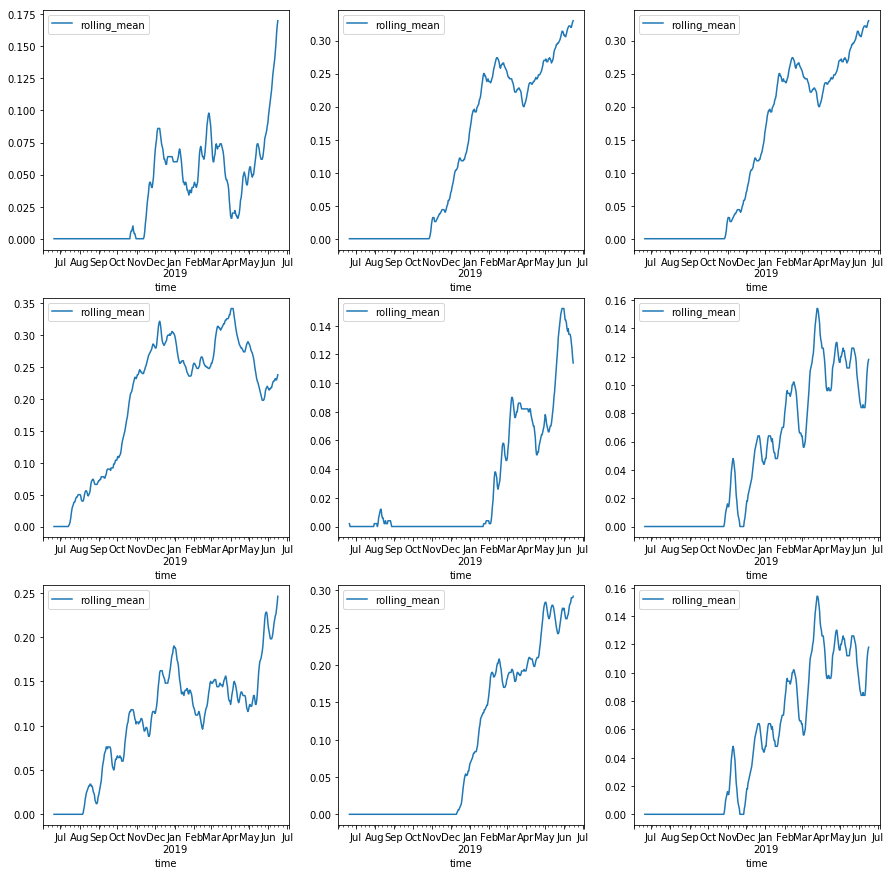

In [94]:
# For each customer draw charges plot 

fig = plt.figure(figsize=(15, 15))
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
customer_ids = df.customer_id.unique()
a = 0
b = 0
customer_ids = random.choice(customer_ids, 20)
style = dict(size=10, color='gray')
for customer_id in customer_ids: 
    if a < 3 and b < 3:
        cus_time_charge = df[['customer_id', 'charge', 'time']]
        update_df = cus_time_charge.loc[df['customer_id'] == customer_id] ## --> to locate these customers charges
        ## by far, there are 2922 * 3 dataframe sliced out from the original dataframe. all the left to do is to make sure
        ## rolling(100) is able to be calculated.
        df_ = update_df.loc[update_df['customer_id'] == customer_id]['charge']
        #print (update_df)
        ## the df_ is in consistent with cus_time_charge in terms of length --> 2922 rows.
        container = df_.rolling(5).mean()
        print(len(container))
        ## 2922 rows
        
        new_cus_time_charge = update_df.assign(rolling_mean = container)
        ## have put the series into the existing dataframe and need to remove all NaN

        new_cus_time_charge = new_cus_time_charge[np.isfinite(new_cus_time_charge['rolling_mean'])]
        ## NaN have been removed by far, end up with 2823 rows.
        #print (new_cus_time_charge)

        ##### to sort the whole dataframe by an English Date Format 
        new_cus_time_charge ['time'] = pd.to_datetime(new_cus_time_charge['time'], format = '%d-%m-%Y')
        sort_nctc = new_cus_time_charge.sort_values('time')
        #print (sort_nctc)
        ## get the whole dataframe sorted by time.

        max_min = sort_nctc['charge']

        sort_nctc.plot(x = 'time', y = 'rolling_mean', ax = axes[a,b])
        
        
    if a < 3:
        a = a + 1
    else: 
        a = 0 
        b = b + 1 
        
   
#fig.savefig('customer_transactions.png')
    

### 1. Machine learns any seasonal patterns in spending and monitors for anomalous spikes in charges 

In [33]:
def rolling_window(data, block):
    shape = data.shape[:-1] + (data.shape[-1] - block + 1, block)
    strides = data.strides + (data.strides[-1],)
    return np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)


roll= rolling_window(df_, 10)
std = 2 * roll.std(axis=1)
mean = roll.mean(axis=1)

C:\Users\kv999xs\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Series.strides is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


Text(2550, 2975, 'O')

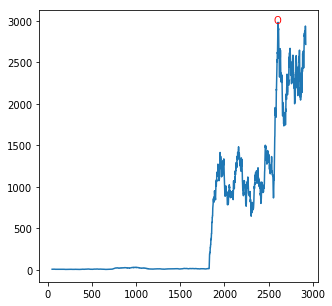

In [32]:
fig, ax= plt.subplots(figsize=(5,5))
df_ = df.loc[df['customer_id'] == 4391838]['charge']
(df_.rolling(50).mean()).plot()
ax.annotate('O', (2600,2980), xytext=(2550,2975), xycoords='data', textcoords='data', color='red')



### 2. Machine learns customer segments based on spending behaviour and seasonal trend 

In [200]:
df = pd.read_csv('EY_overdraft_charges_seasonal_0723_19062019.csv')

In [201]:
df_customer_mean = df.groupby(['customer_id']).mean()

In [202]:
df_customer_balance_charge = df_customer_mean[['seasonal_index', 'charge']]
df_customer_balance_charge.head()

seasonal_index       charge
customer_id                             
1002797            1.640822    32.823532
1020766           24.414273   176.217406
1033119           45.089551  1109.778395
1037908           44.658543   422.718190
1041041           37.742827  1392.149463

In [5]:
# Perform unsupervised cllustering  
def ClusterGenerator(write_to_file=0): 
    plt.figure(figsize=(15,10))
    
    
    # create normal clusters
    cluster_centers = [[25,25], [10, 6], [20, 10], [10,20]]
    X,y = make_blobs(n_samples=500, n_features=2, centers=cluster_centers, cluster_std=1.6, random_state=100)
    
    # create anomalous clusters 
    cluster_centers = [[20,18], [12, 7]]
    M,n = make_blobs(n_samples=50, n_features=2, centers=cluster_centers, cluster_std=0.5, random_state=100)
    
    # create more anomalous clusters 
    cluster_centers = [[25,3], [28, 15]]
    P,Q = make_blobs(n_samples=20, n_features=2, centers=cluster_centers, cluster_std=0.5, random_state=100)
  
    # Lone clusters
    cluster_centers = [[5,25], [5,15]]
    W,U = make_blobs(n_samples=2, n_features=2, centers=cluster_centers, cluster_std=0.5, random_state=100)
    
    L = np.concatenate((X, M))
    I  = np.concatenate((L, W))
    Z = np.concatenate((I, P))
    
    clf = KMeans(n_clusters=7,  random_state=0)
    clf.fit(Z)
    

    # create scatter plot
    axes = plt.scatter(Z[:,0], Z[:,1], c=clf.labels_, cmap='viridis')
    
    plt.xlim(0,30)
    plt.ylim(0,30)
    plt.xlabel('Size index')
    plt.ylabel('Overdraft volume index')
    
    if write_to_file != 0: 
        df = pd.DataFrame(data=Z, columns=['x','y'])
        df['label'] = clf.labels_
        
        df.to_csv(write_to_file)

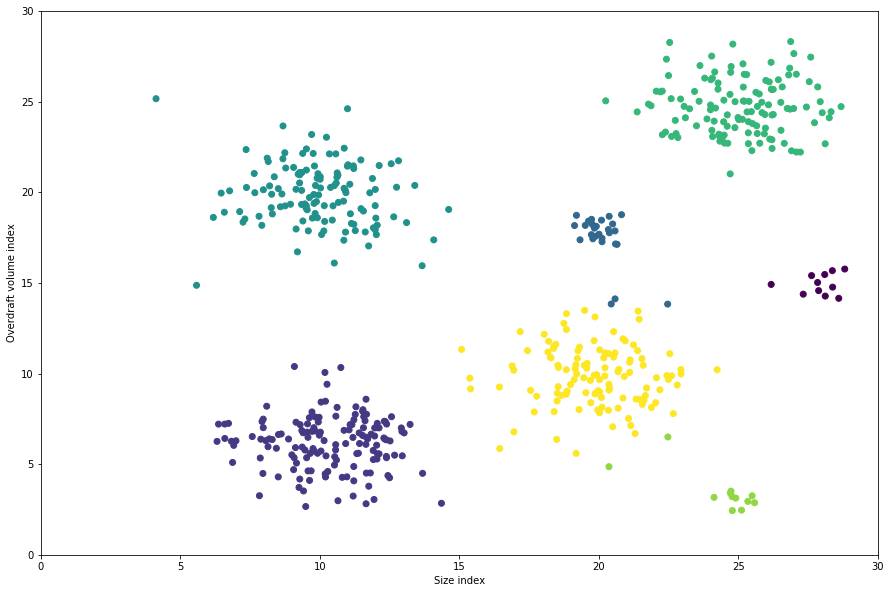

In [6]:
ClusterGenerator('cluster_data.csv')

In [205]:
X=customer_balance_mat

In [210]:
kmeans = KMeans(n_clusters=4, random_state=0).fit_predict(X)

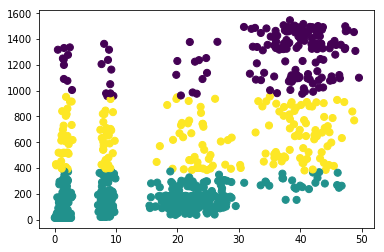

In [211]:
plt.scatter(X[:, 0], X[:, 1], c=kmeans,
            s=50, cmap='viridis');